# Fit Rankine, Holland, Willoughby and Chavas profiles on SAR data
Note that so far the Rmax is searched in the first 200km around the TC center (in the code this impacts how the functions are initialized, but also when the curves are plot (on the smaller scale graph).

For the fitting, we constrain Rmax > 5km which works well for a lot of TCs. 

In the papers of Holland, Willoughby and Chavas, the wind used is the tangential wind (same for Rankine). 

TODO:

==> Translate Chavas by Vmin; DONE

==> Which profiles work when? etc...

==> Chavas looks worse, but this is because the other profiles use curve_fit(). Try to define the other profiles just with the input parameters. DONE


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit

import glob

import functions as f

In [2]:
### PATHS
dir_path = '/home/arthur/data/cyclobs/rotated_files/'
all_data = glob.glob(dir_path + "*.nc")
print("Total number of files:", len(all_data))
# Savepath to be modified directly in the function

### PARAMS
PARAMS = {
    'r_window_len':          501,  # Scale for radius (km)
    'rmax_window':           300,  # Window in whick we look for Rmax (e.g [0, 200km])
    'chavas_vfit':           17,
    'chavas_vmin':           True, # Translates the profile from Vmin if True
    'use_curve_fit':         True,
    'tangential_wind_speed': True, # If False, total wind speed is used
    'print_values':          False, 
    'save_dir':              "/home/arthur/results/windProfiles/test/"
    }

Total number of files: 384


In [3]:
# INITIALIZE DATA STRUCTURE
INI = {           # Initial values
    'Rankine':    [], # x, alpha, Vmin, Rmax
    'Holland':    [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'Willoughby': [], # n, X1, Vmin, Rmax, Vmax
    'Chavas':     []  # Vmax, Vmin, Rfit, Vfit, fcor, Cdvary, Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye
    } 
FIT = {           # Fit values
    'Rankine':    [], # x, alpha, Vmin, Rmax
    'Holland':    [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'Willoughby': [], # n, X1, Vmin, Rmax, Vmax
    'Chavas':     []  # rr, VV, rmax, r0, rmerge, Vmerge
    } 

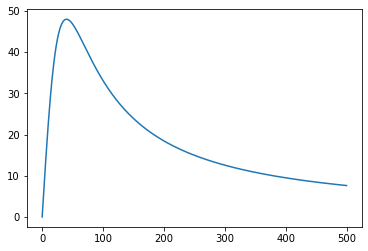

In [4]:
### DEFINE CHAVAS INNER PROFILE FUNCTION
def chavas_inner_profile(r, Lat, Rmax, Vmax):
    '''We assume that Ck/Cd = 1'''
    fcor       = f.coriolis(Lat)
    CkCd_ratio = 1. 
    
    M   = r * 0.
    Mm  = Rmax * Vmax + 0.5 * fcor * Rmax ** 2
    M   = Mm * (2 * (r / Rmax) ** 2 / (2 - CkCd_ratio + CkCd_ratio * (r / Rmax) ** 2)) ** (1 / (2 - CkCd_ratio))
    
    V   = (M / r) - 0.5 * fcor * r
    return V

def dM_dr_SAR(r, V, Lat):
    fcor  = f.coriolis(Lat)
    dM_dr = r * 0.
    dr    = r[1] - r[0]
    dM_dr = V + r * np.gradient(V, dr) + 2 * fcor * r
    return dM_dr
    
def chavas_outer_profile(r, V, khi, r0):
    dM_dr = khi * ((r * V) ** 2) / (r0 ** 2 - r ** 2) 
    return dM_dr

# Print the shape
r = np.arange(501) + 0.001 # To avoid dividing by zero
V = chavas_inner_profile(r, Lat=20, Rmax=40, Vmax=48) 
plt.plot(r, V)

1 =>     /home/arthur/data/cyclobs/rotated_files/s1b-ew-owi-cm-20180902t143708-20180902t143912-000003-01720F_ll_gd_rotated.nc
Initialization values ==> 21 ,  47.37
Final values ========> [28.08 38.47]


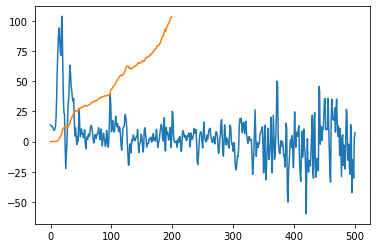

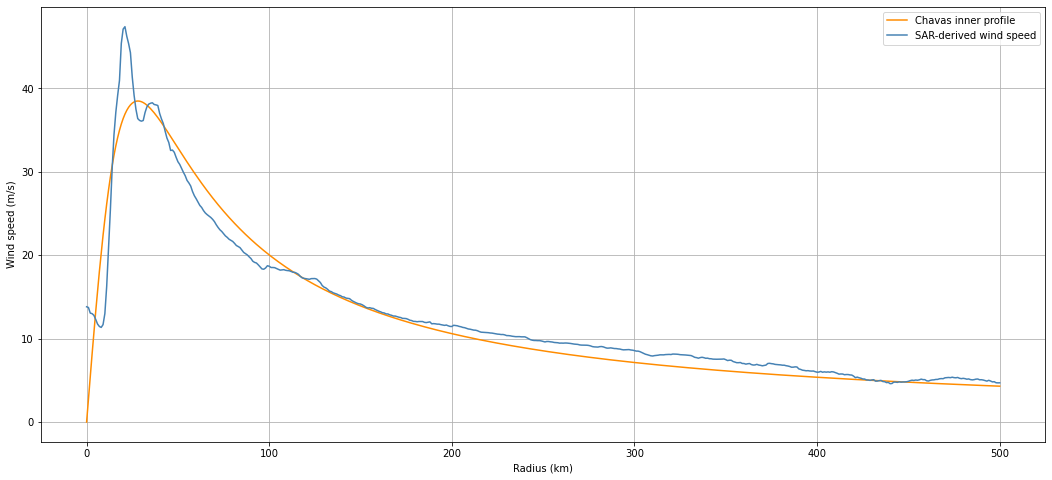

In [5]:
i   = 0
for file in all_data[:1]:
    i += 1
    print(i, "=>    ", file)
    # Open file and compute mean wind speed
    ds      = xr.open_dataset(file)
    if PARAMS['tangential_wind_speed']:
        spdm = f.compute_mean_tangential_wind_spd(ds, r_window_len=PARAMS['r_window_len']) # TANGENTIAL WIND SPEED
    else:
        spdm = f.compute_mean_wind_spd(ds, r_window_len=PARAMS['r_window_len'])         # TOTAL WIND SPEED
    
    # Debug
    if 1 == 0: # DEBUG
        f.print_ds(ds)
        f.print_spd(ds)
        print(spdm)
    
    r, spdm, first_valid_index = f.initialize_radius(spdm)
    
    ### INNER PROFILE
    # Initialize profile
    Lat    = np.float64(ds['lat_ref'])
    Rmax   = np.argmax(spdm[:100]) # 40
    Vmax   = np.max(spdm[:100]) # 48
        
    # Fit profile to data
    print("Initialization values ==>", Rmax, ", ", "{:.2f}".format(Vmax))
    popt, pcov = curve_fit(lambda r , Rmax, Vmax: chavas_inner_profile(r, Lat, Rmax, Vmax), r, spdm, p0=[Rmax, Vmax], bounds=((5, 0), (500, 150)))
    print("Final values ========>", np.around(popt, decimals=2)) # Caveat: Real VMAX = Vmax + Vmin
    
    ### OUTER PROFILE
    # Initialize profile
    khi    = 1.
    r0     = 300.
    
    dM_dr     = chavas_outer_profile(r, spdm, khi, r0)
    dM_dr_S   = dM_dr_SAR(r, spdm, Lat)
    plt.plot(r, dM_dr_S)
    plt.plot(r[:200], dM_dr[:200])
    

    # Print the results
    V_fit = chavas_inner_profile(r, Lat, popt[0], popt[1])
    plt.figure(figsize=(18, 8))
    fig1  = plt.plot(r, V_fit, color='darkorange', label='Chavas inner profile')    # V_fit
    fig2  = plt.plot(r, spdm,  color='steelblue',  label='SAR-derived wind speed')  # V_obs
    plt.xlabel('Radius (km)')
    plt.ylabel('Wind speed (m/s)')
    plt.legend();plt.grid()